# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import boto3
import os
from dotenv import load_dotenv
load_dotenv()

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [2]:
import boto3
import os
from dotenv import load_dotenv
load_dotenv()

def get_session_student():
    session = boto3.session.Session()
    return session.client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID_STUDENT'),
        aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY_STUDENT')
    )
 
s3 = get_session_student()
bucket_name = os.environ.get('S3_BUCKET_NAME')
 
if s3.list_objects(Bucket=bucket_name).get('Contents'):
    for key in s3.list_objects(Bucket=bucket_name)['Contents']:
        print(key['Key'])


# s3.delete_object(Bucket='s3-student-mle-20240625-3348db98ef', Key='data/initial_data.csv')

10/2e6aa7fca0074270835b798cddee6024/artifacts/dataframe/cleaned_flats_data.csv
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/MLmodel
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/conda.yaml
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/input_example.json
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/model.cb
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/python_env.yaml
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/requirements.txt
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/dataframe/cleaned_flats_data.csv
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/MLmodel
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/conda.yaml
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/input_example.json
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/model.pkl
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/python_env.yaml
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/requirements.txt
10/6da881fd8ae846329c0207d7af3243b3/artifacts/dataframe/c

In [5]:
import io
import csv

def load_csv_from_s3(bucket_name, key_name, s3_client):
    """
    Load a CSV file from S3 into memory.
    Args:
        bucket_name (str): The name of the S3 bucket.
        key_name (str): The object key in S3.
        s3_client: Boto3 S3 client.
    Returns:
        list: A list of rows from the CSV file.
    """
    # Create a buffer
    csv_buffer = io.BytesIO()
    
    # Download the file into the buffer
    s3_client.download_fileobj(bucket_name, key_name, csv_buffer)
    
    # Reset the buffer's position to the start
    csv_buffer.seek(0)
    
    # Read the CSV from the buffer
    csv_reader = csv.reader(io.TextIOWrapper(csv_buffer, encoding='utf-8'))
    rows = list(csv_reader)  # Convert to a list of rows
    return rows

# Call the function to load the CSV
als_recommendations = load_csv_from_s3(
    bucket_name=bucket_name,
    key_name='recsys/data/als_recommendations.csv',
    s3_client=s3
)


In [12]:
for i in range(3):
    print(als_recommendations[i])

['user_id', 'item_ids', 'scores']
['0', '275375,265629,381971,339789,282821,334138,347129,273369,217691,341440,280965,244600,221431,270458,308161,303527,296630,357305,342922,295936,307689,330464,339516,330401,384646,281950,223694,395826,287405,150675,307117,372756,384240,346372,196484,359454,353182,361435,338808,368654,380690,297129,276615,278750,385459,146858,237991,289481,244930,308801', '0.024032095,0.021947345,0.021340216,0.02116209,0.018825246,0.018749105,0.018598147,0.0184359,0.017945394,0.017935317,0.01771035,0.017701238,0.017419694,0.017080275,0.017061008,0.017039072,0.016647628,0.016442424,0.016253436,0.016218517,0.016213216,0.01605447,0.016006913,0.015540657,0.0155136045,0.015504968,0.014964655,0.014931646,0.014825653,0.014800899,0.0147728585,0.01460564,0.014505247,0.014467254,0.014449484,0.014408672,0.014329691,0.014276411,0.014205804,0.014149512,0.014119548,0.014108205,0.013888743,0.013869556,0.013830721,0.013405381,0.013338411,0.013331823,0.013264987,0.013171654']
['1', '8

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet("data/tracks.parquet")
catalog = pd.read_parquet("data/catalog_names.parquet")
interactions = pd.read_parquet("data/interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
tracks.info()
tracks.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


,track_id,albums,artists,genres
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"
999999,101521819,[21414638],[5056591],"[3, 75]"


In [5]:
catalog.info()
catalog.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


,id,type,name
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва
1812470,101521819,track,Вокзал


In [6]:
interactions.info()
interactions.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


,user_id,track_id,track_seq,started_at
287,1374582,95514767,288,2022-12-29
288,1374582,97220301,289,2022-12-29
289,1374582,97241171,290,2022-12-29
290,1374582,98542641,291,2022-12-29
291,1374582,100736375,292,2022-12-30


In [7]:
# Приведем тип user_id и track_id к int64

interactions.reset_index(drop=True, inplace=True )
interactions['user_id'] = interactions['user_id'].astype('int64')
interactions['track_id'] = interactions['track_id'].astype('int64')

In [8]:
# Проверим наличие в треках неизвестных идентификаторов альбомов

all_album_ids = set(catalog.loc[catalog['type'] == 'album', 'id'])
potentially_unidentified_albums = tracks[~tracks['albums'].apply(set).apply(lambda x: x.issubset(all_album_ids))]
potentially_unidentified_albums

,track_id,albums,artists,genres


In [9]:
# Проверим наличие в треках неизвестных идентификаторов исполнителей

all_artist_ids = set(catalog.loc[catalog['type'] == 'artist', 'id'])
potentially_unidentified_artists = tracks[~tracks['artists'].apply(set).apply(lambda x: x.issubset(all_artist_ids))]
potentially_unidentified_artists

,track_id,albums,artists,genres


In [10]:
# Проверим наличие в треках неизвестных идентификаторов жанров

all_genres_ids = set(catalog.loc[catalog['type'] == 'genre', 'id'])
exploded_tracks = tracks.explode('genres')
unidentified_genres = exploded_tracks[~exploded_tracks['genres'].apply(lambda x: True if x in all_genres_ids else False)]

In [11]:
genre_ids = list(unidentified_genres['genres'].dropna().unique())
genre_types = ['genre' for i in range(len(genre_ids))]
genre_names = ['other' for i in range(len(genre_ids))]

added_genres = pd.DataFrame({'id':genre_ids,
                             'type':genre_types,
                             'name':genre_names})
catalog = pd.concat([catalog, added_genres], ignore_index=True)

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [12]:
# С данными явных проблем не замечено, пришлось лишь привести колонки id треков 
# и пользователей из таблицы interactions, а также домоплнить таблицу каталога 30ю 
# идентификаторами неизвестных жанров и отнести их к категории other.

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

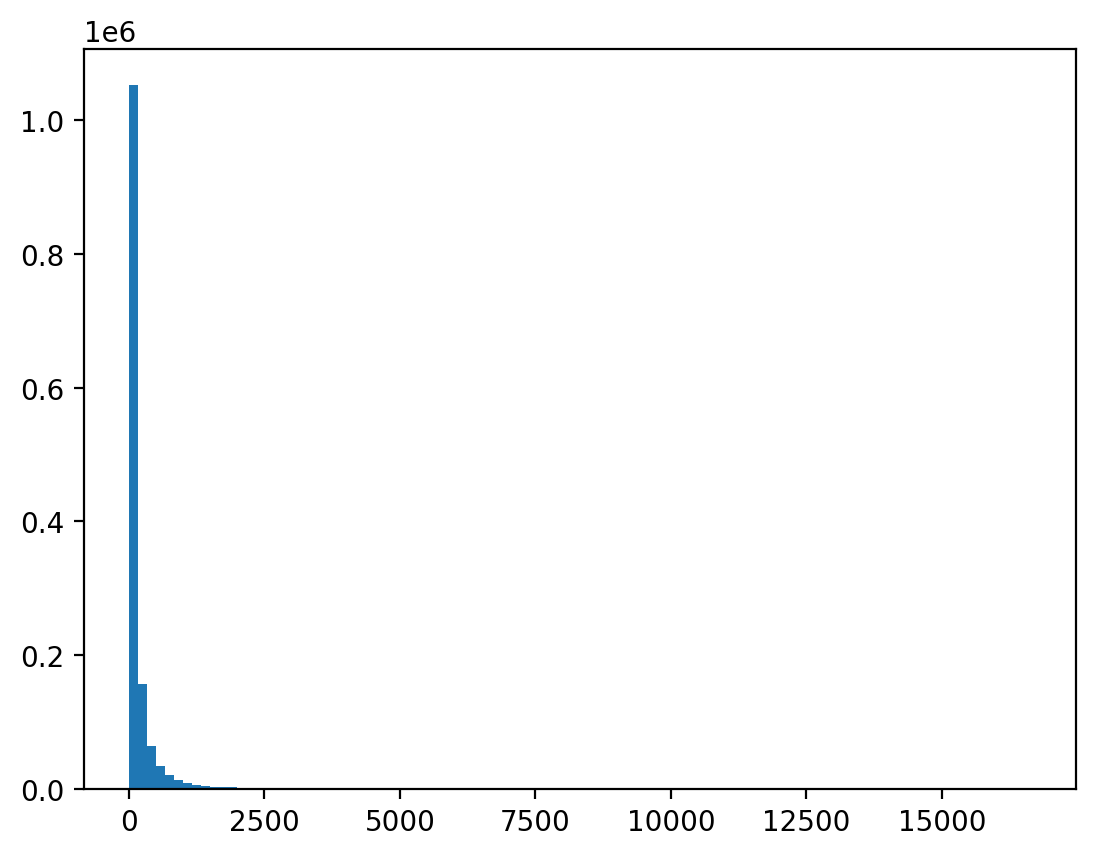

In [13]:
user_aggregate_plays = interactions.groupby('user_id')\
    .agg({'track_id': 'count'})\
        .rename(columns={'track_id': 'n_tracks'})
user_aggregate_plays = user_aggregate_plays.sort_values(by='n_tracks',
                                                        ascending=False).reset_index()
user_aggregate_plays_under_50 = user_aggregate_plays[user_aggregate_plays['n_tracks'] < 50]['n_tracks'].reset_index(drop=True)
plt.hist(user_aggregate_plays['n_tracks'], bins=100);

(0.0, 30.0)

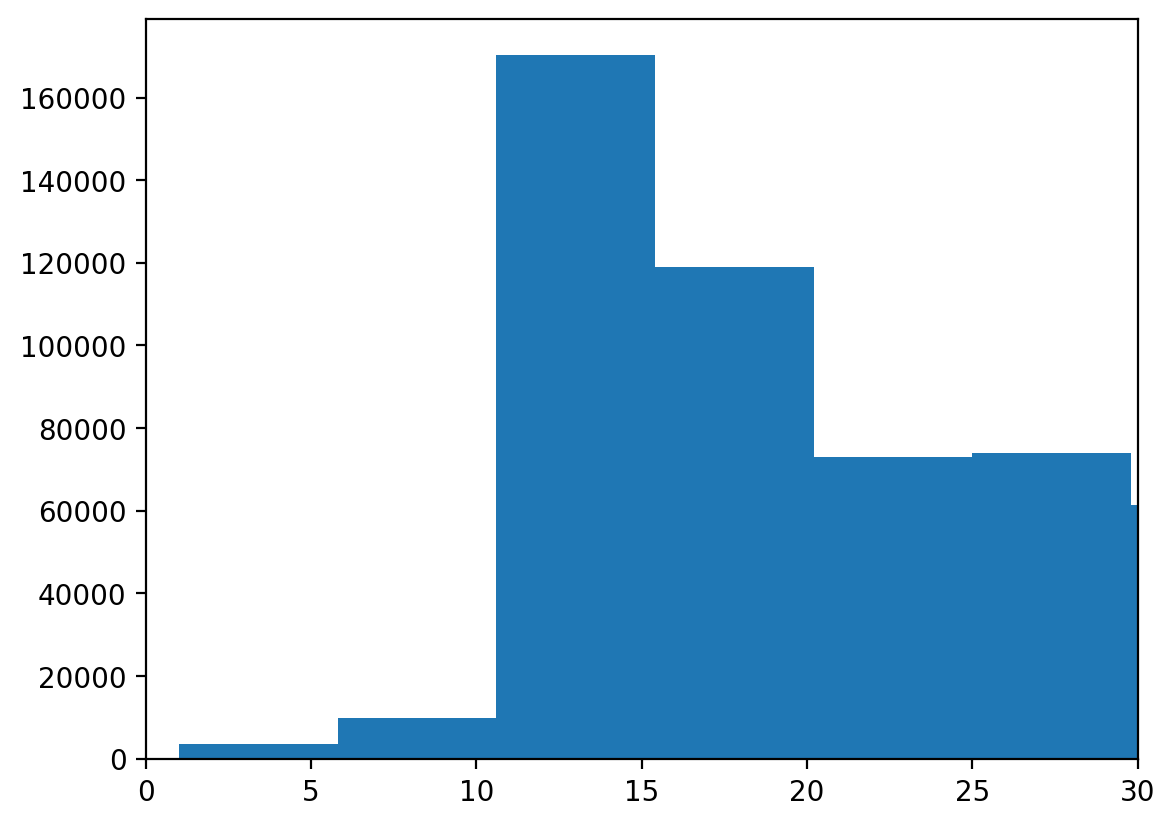

In [14]:
plt.hist(user_aggregate_plays_under_50)
plt.xlim(0, 30)

Наиболее популярные треки

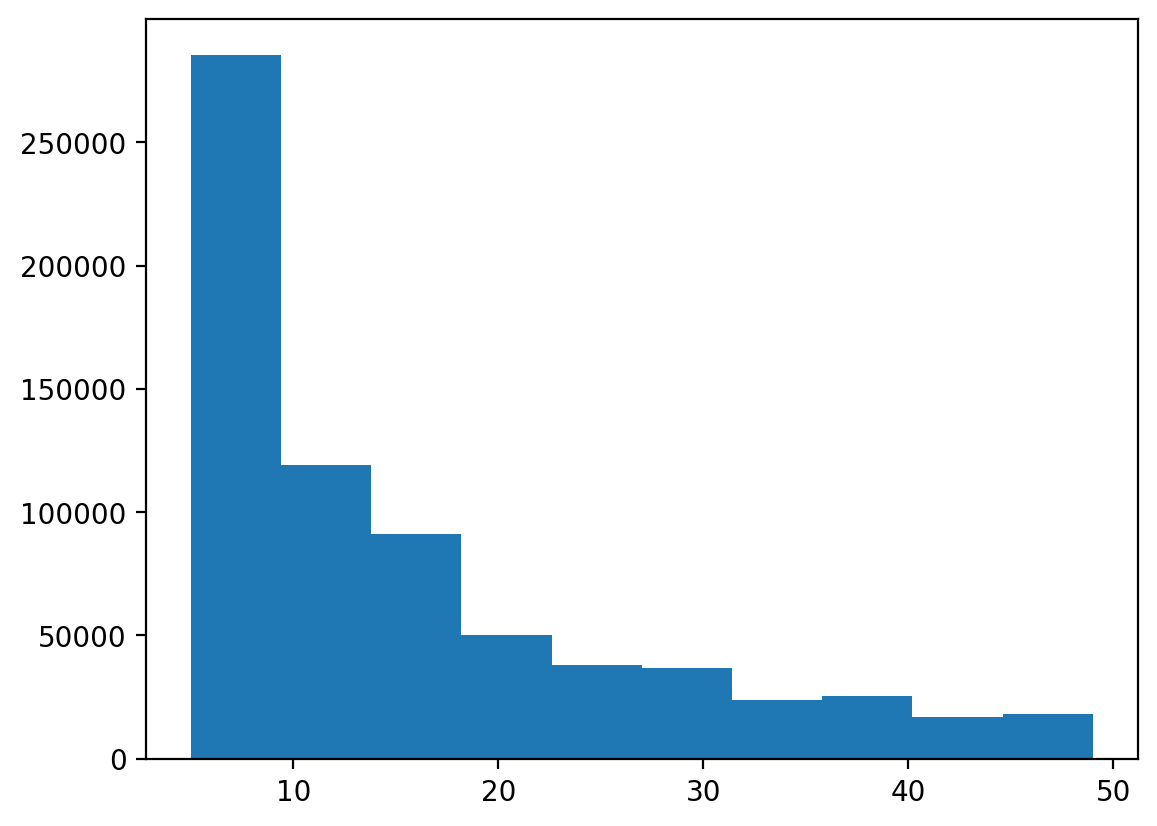

In [15]:
track_aggregate_plays = interactions.groupby('track_id')\
    .agg({'user_id': 'count'})\
        .rename(columns={'user_id': 'num_plays'})
track_aggregate_plays = track_aggregate_plays.sort_values(by='num_plays', 
                                                          ascending=False).reset_index()
track_aggregate_plays_under_50 = track_aggregate_plays[track_aggregate_plays['num_plays'] < 50]['num_plays'].reset_index(drop=True)
plt.hist(track_aggregate_plays_under_50);
# plt.xlim(0, 30)

In [16]:
pd.merge(track_aggregate_plays, 
         catalog[catalog['type'] == 'track'][['id', 'name']],
         left_on='track_id',
         right_on='id',
         how='left').head(10)

,track_id,num_plays,id,name
0,53404,111062,53404,Smells Like Teen Spirit
1,33311009,106921,33311009,Believer
2,178529,101924,178529,Numb
3,35505245,99490,35505245,I Got Love
4,65851540,86670,65851540,Юность
5,24692821,86246,24692821,Way Down We Go
6,32947997,85886,32947997,Shape of You
7,51241318,85244,51241318,In The End
8,795836,85042,795836,Shape Of My Heart
9,45499814,84748,45499814,Life


Топ 5 треков от nirvana, imagine dragons, lin park и муджус

Наиболее популярные жанры

In [17]:
enriched_track_plays=  pd.merge(track_aggregate_plays, 
                                tracks[['track_id', 'genres']], 
                                left_on='track_id',
                                right_on='track_id', 
                                how='left')

enriched_track_plays_exploded = enriched_track_plays.explode('genres')
genres_agg = enriched_track_plays_exploded.groupby('genres')\
    .agg({'num_plays':'sum'})\
        .sort_values('num_plays', ascending=False)\
            .reset_index()

pd.merge(genres_agg,
         catalog[catalog['type'] == 'genre'][['id', 'name']],
         left_on='genres',
         right_on='id').head(10)

,genres,num_plays,id,name
0,11,55578312,11,pop
1,75,37799821,75,rap
2,102,31092013,102,allrock
3,20,26626241,20,ruspop
4,3,25303695,3,rusrap
5,68,20120981,68,electronics
6,16,16291557,16,dance
7,2,13166147,2,rusrock
8,14,12772644,14,rock
9,47,12437375,47,metal


Видим, что самые популярные жанры - поп, рэп, рок, русские поп и рэп

Треки, которые никто не прослушал

In [18]:
set(tracks['track_id']) - set(enriched_track_plays['track_id'])

set()

In [19]:
enriched_track_plays[enriched_track_plays['num_plays'] == 5]

,track_id,num_plays,genres
946210,26,5,"[11, 21]"
946211,101223525,5,"[44, 75]"
946212,101223837,5,[70]
946213,101224609,5,"[11, 20]"
946214,101227724,5,[16]
...,...,...,...
999995,84391078,5,[62]
999996,84391079,5,[62]
999997,84391080,5,[62]
999998,34766819,5,[13]


Прям совсем непрослушанных треков нет, но наименее прослушанныых треков 53к записей из 1kk

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [4]:
items = tracks.copy()
events = interactions.copy()

del tracks 
del interactions

In [5]:
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
catalog    DataFrame                    id   type<...>1812471 rows x 3 columns]
events     DataFrame         user_id   track_id  <...>2629898 rows x 4 columns]
items      DataFrame             track_id        <...>1000000 rows x 4 columns]


In [22]:
del added_genres
del catalog 
del enriched_track_plays
del enriched_track_plays_exploded
del exploded_tracks
del genres_agg
del potentially_unidentified_albums
del potentially_unidentified_artists
del track_aggregate_plays
del unidentified_genres
del user_aggregate_plays

In [6]:
user_counts = events['user_id'].value_counts()
uids = user_counts[user_counts > 5].index

filtered_events = events[events['user_id'].isin(uids)]
# filtered_events.sort_values(by='user_id', inplace=True)
filtered_events.reset_index(drop=True, inplace=True)

cols_to_rename = {'track_id': 'item_id'}
filtered_events.rename(columns=cols_to_rename, inplace=True)
items.rename(columns=cols_to_rename, inplace=True)

/tmp/ipykernel_3147/1875784261.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_events.rename(columns=cols_to_rename, inplace=True)


In [10]:
filtered_events

,user_id,item_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22
...,...,...,...,...
222619418,1374582,95514767,288,2022-12-29
222619419,1374582,97220301,289,2022-12-29
222619420,1374582,97241171,290,2022-12-29
222619421,1374582,98542641,291,2022-12-29


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [18]:
import io

def put_df_to_s3(df: pd.DataFrame, bucket_name: str, file_key: str, s3_client):
    buffer = io.BytesIO()
    df.to_parquet(buffer, index=False)
    buffer.seek(0)
    
    s3_client.put_object(Bucket=bucket_name, Key=file_key, Body=buffer)
    print(f"Uploaded {file_key} to {bucket_name}.")

put_df_to_s3(filtered_events, bucket_name, 'recsys/data/events.parquet', s3)
put_df_to_s3(items, bucket_name, 'recsys/data/items.parquet', s3)
put_df_to_s3(catalog, bucket_name, 'recsys/data/catalog.parquet', s3)


Uploaded recsys/data/events.parquet to s3-student-mle-20240625-3348db98ef.
Uploaded recsys/data/items.parquet to s3-student-mle-20240625-3348db98ef.
Uploaded recsys/data/catalog.parquet to s3-student-mle-20240625-3348db98ef.


In [ ]:
 
if s3.list_objects(Bucket=bucket_name).get('Contents'):
    for key in s3.list_objects(Bucket=bucket_name)['Contents']:
        print(key['Key'])

10/2e6aa7fca0074270835b798cddee6024/artifacts/dataframe/cleaned_flats_data.csv
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/MLmodel
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/conda.yaml
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/input_example.json
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/model.cb
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/python_env.yaml
10/2e6aa7fca0074270835b798cddee6024/artifacts/model/requirements.txt
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/dataframe/cleaned_flats_data.csv
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/MLmodel
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/conda.yaml
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/input_example.json
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/model.pkl
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/python_env.yaml
10/5c1384ee8e324fe9ae72161c4ed40234/artifacts/model/requirements.txt
10/6da881fd8ae846329c0207d7af3243b3/artifacts/dataframe/c

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [20]:
%whos DataFrame

Variable          Type         Data/Info
----------------------------------------
catalog           DataFrame                    id   type<...>1812471 rows x 3 columns]
events            DataFrame         user_id   track_id  <...>2629898 rows x 4 columns]
filtered_events   DataFrame               user_id    ite<...>2619423 rows x 4 columns]
items             DataFrame              item_id        <...>1000000 rows x 4 columns]


In [21]:
del events

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [ ]:
import boto3
import os
import io
import csv
from dotenv import load_dotenv
load_dotenv()

def get_session_student():
    session = boto3.session.Session()
    return session.client(
        service_name='s3',
        endpoint_url='https://storage.yandexcloud.net',
        aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID_STUDENT'),
        aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY_STUDENT')
    )

def load_csv_from_s3(bucket_name, key_name, s3_client):
    csv_buffer = io.BytesIO()
    s3_client.download_fileobj(bucket_name, key_name, csv_buffer)
    csv_buffer.seek(0)
    csv_reader = csv.reader(io.TextIOWrapper(csv_buffer, encoding='utf-8'))
    rows = list(csv_reader) 
    return rows
 
s3 = get_session_student()
bucket_name = os.environ.get('S3_BUCKET_NAME')

events = load_csv_from_s3(
    bucket_name=bucket_name,
    key_name='recsys/data/events.parquet',
    s3_client=s3
)

items = load_csv_from_s3(
    bucket_name=bucket_name,
    key_name='recsys/data/items.parquet',
    s3_client=s3
)

# als_recommendations = load_csv_from_s3(
#     bucket_name=bucket_name,
#     key_name='recsys/data/als_recommendations.csv',
#     s3_client=s3
# )

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [36]:
date_to_slice_by = pd.to_datetime('2022-12-16')
train_idices = events['started_at'] < date_to_slice_by

events_train = events[train_idices].copy()
events_test = events[~train_idices].copy()

In [43]:
users_train = events_train['user_id'].drop_duplicates()
users_test = events_test['user_id'].drop_duplicates()

common_users = set(users_train).intersection(set(users_test))
cold_users = list(set(users_test) - set(users_train))

print('Num users in train: ', str(len(users_train)))
print('Num users in test: ', str(len(users_test)))
print('Num common users: ', str(len(common_users)))
print('Num cold users: ', str(len(cold_users)))

Num users in train:  1339127
Num users in test:  781881
Num common users:  751404
Num cold users:  30477


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [47]:
track_aggregate_plays = events.groupby('item_id')\
    .agg({'user_id': 'count'})\
        .rename(columns={'user_id': 'num_plays'})
track_aggregate_plays = track_aggregate_plays.sort_values(by='num_plays', 
                                                          ascending=False).reset_index()

In [51]:
catalog

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack
...,...,...,...
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва


In [56]:
top_popular = pd.merge(track_aggregate_plays.loc[:99, :], 
                       catalog[catalog['type'] == 'track'], 
                       left_on='item_id', 
                       right_on='id',
                       how='left').drop(['id', 'type'], axis=1)

put_df_to_s3(top_popular, bucket_name, 'recsys/data/top_popular.parquet', s3)

Uploaded recsys/data/top_popular.parquet to s3-student-mle-20240625-3348db98ef.


# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.